## Matrix factorization: decomposition to a special matices, e.g. SVD,  SVD++, NMF, QR, LQ, RQ, RZ 
https://ru.wikipedia.org/wiki/%D0%A4%D0%B0%D0%BA%D1%82%D0%BE%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F


**SVD (Singular Vector Decomposition) for recommender engine**
https://habr.com/ru/articles/751470/

**Matrix Factorization for recommending engines**
https://heartbeat.comet.ml/recommender-systems-with-python-part-iii-collaborative-filtering-singular-value-decomposition-5b5dcb3f242b


In [43]:
import os
import requests
import warnings
import zipfile
import pandas as pd
import numpy as np
import keras.models as kmodels
import keras.layers as klayers
import keras.backend as K
import keras
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix, coo_array
from sklearn import dummy, metrics, ensemble

In [44]:
%matplotlib inline

In [4]:
# Download the dataset. It's small, only about 6 MB.
DATA_PATH = os.path.join("data", "ml-1m")
DATA_URL = "http://files.grouplens.org/datasets/movielens/ml-1m.zip"

if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)
    response = requests.get(DATA_URL, stream=True)
    total_length = response.headers.get("content-length")

    with open(os.path.join(DATA_PATH, "ml-1m.zip"), "wb") as f:
        for data in response.iter_content(chunk_size=4096):
            f.write(data)
    zip_ref = zipfile.ZipFile(os.path.join(DATA_PATH, "ml-1m.zip"), "r")
    zip_ref.extractall(DATA_PATH)
    zip_ref.close()
else:
    warnings.warn(f"Directory {DATA_PATH} already esist")

/var/folders/_z/b4ffpzvj0_x8rgpm8jksnzbc0000gn/T/ipykernel_16105/1103988928.py:17: UserWarning: Directory data/ml-1m already esist
  warnings.warn(f"Directory {DATA_PATH} already esist")


In [5]:
# Read in the dataset, and do a little preprocessing,
# mostly to set the column datatypes.

# use encoding = "ISO-8859-1" to avoid error: "utf-8' codec can't decode byte..."
users = pd.read_csv(os.path.join(DATA_PATH, "ml-1m", 'users.dat'), sep='::',
                    engine='python',
                    names=['userid', 'gender', 'age', 'occupation', 'zip'],
                    encoding="ISO-8859-1").set_index('userid')
ratings = pd.read_csv(os.path.join(DATA_PATH, "ml-1m", 'ratings.dat'), engine='python',
                      sep='::', names=['userid', 'movieid', 'rating', 'timestamp'],
                      encoding="ISO-8859-1")
movies = pd.read_csv(os.path.join(DATA_PATH, "ml-1m", 'movies.dat'), engine='python',
                     sep='::', names=['movieid', 'title', 'genre'],
                     encoding="ISO-8859-1").set_index('movieid')
movies['genre'] = movies.genre.str.split('|')

users.age = users.age.astype('category')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('int')
ratings.userid = ratings.userid.astype('int')
ratings.rating = ratings.rating.astype('float')

In [6]:
print(ratings.userid.max())
print(ratings.movieid.max())

6040
3952


In [7]:
print(users.shape)
print(movies.shape)

ratings_shape = (ratings.userid.max()+1, ratings.movieid.max()+1)
print(ratings_shape)

(6040, 4)
(3883, 2)
(6041, 3953)


In [8]:
train_set, test_set = train_test_split(ratings, test_size=0.05)

In [9]:
train_matrix = coo_matrix(
    (test_set.rating.to_numpy(),
     (test_set.userid.to_numpy(), test_set.movieid.to_numpy())
     ),
    shape=ratings_shape
)

**Factorization based on SVD**

In [11]:
# Matrix factorization using SVD

U, S, Vh = svds(
    train_matrix, k=100
)
print(U.shape)
print(S.shape)
print(Vh.shape)

(6041, 100)
(100,)
(100, 3953)


## Recomending engine based on Keras

source: https://github.com/ririw/ririw.github.io/blob/master/assets/Recommending%20movies.ipynb

In [26]:
ratings.movieid = ratings.movieid.astype('category')
ratings.userid = ratings.userid.astype('category')
ratings.rating = ratings.rating.astype('int')

# Count the movies and users
n_movies = movies.shape[0]
n_users = users.shape[0]

# Also, make vectors of all the movie ids and user ids. These are
# pandas categorical data, so they range from 1 to n_movies and 1 to n_users, respectively.
movieid = ratings.movieid.cat.codes.values
userid = ratings.userid.cat.codes.values

In [27]:
# And finally, set up a y variable with the rating,
# as a one-hot encoded matrix.
#
# note the '- 1' for the rating. That's because ratings
# go from 1 to 5, while the matrix columns go from 0 to 4

y = np.zeros((ratings.shape[0], 5))
y[np.arange(ratings.shape[0]), ratings.rating - 1] = 1

In [28]:
# Dummy classifier! Just see how well stupid can do.
pred = dummy.DummyClassifier(strategy='prior')
pred.fit(ratings[['userid', 'movieid']], ratings.rating)

print(metrics.mean_absolute_error(ratings.rating,
      pred.predict(ratings[['userid', 'movieid']])))

0.8709609691574461


In [29]:
# Now, the deep learning classifier

# First, we take the movie and vectorize it.
# The embedding layer is normally used for sequences (think, sequences of words)
# so we need to flatten it out.
# The dropout layer is also important in preventing overfitting
movie_input = keras.layers.Input(shape=[1])
movie_vec = keras.layers.Flatten()(
    keras.layers.Embedding(n_movies + 1, 32)(movie_input))
movie_vec = keras.layers.Dropout(0.5)(movie_vec)

# Same thing for the users
user_input = keras.layers.Input(shape=[1])
user_vec = keras.layers.Flatten()(
    keras.layers.Embedding(n_users + 1, 32)(user_input))
user_vec = keras.layers.Dropout(0.5)(user_vec)

In [30]:
print(movie_vec.shape)
print(user_vec.shape)

(None, 32)
(None, 32)


In [32]:
# Next, we join them all together and put them
# through a pretty standard deep learning architecture

# merge is deprecated
# input_vecs = keras.layers.merge([movie_vec, user_vec], mode='concat')

input_vecs = keras.layers.Concatenate(axis=1)([movie_vec, user_vec])
nn = keras.layers.Dropout(0.5)(
    keras.layers.Dense(128, activation='relu')(input_vecs))
nn = keras.layers.BatchNormalization()(nn)
nn = keras.layers.Dropout(0.5)(keras.layers.Dense(128, activation='relu')(nn))
nn = keras.layers.BatchNormalization()(nn)
nn = keras.layers.Dense(128, activation='relu')(nn)

# Finally, we pull out the result!
result = keras.layers.Dense(5, activation='softmax')(nn)

# And make a model from it that we can actually run.
model = kmodels.Model([movie_input, user_input], result)
model.compile('adam', 'categorical_crossentropy')

# If we wanted to inspect part of the model, for example, to look
# at the movie vectors, here's how to do it. You don't need to
# compile these models unless you're going to train them.
final_layer = kmodels.Model([movie_input, user_input], nn)
movie_vec = kmodels.Model(movie_input, movie_vec)

In [33]:
# Split the data into train and test sets...
a_movieid, b_movieid, a_userid, b_userid, a_y, b_y = train_test_split(
    movieid, userid, y)

In [34]:
# And of _course_ we need to make sure we're improving, so we find the MAE before
# training at all.
metrics.mean_absolute_error(
    np.argmax(b_y, 1)+1, np.argmax(model.predict([b_movieid, b_userid]), 1)+1)

7815/7815 [==============================] - 10s 1ms/step


1.293681739471232

23443/23443 [==============================] - 88s 4ms/step - loss: 1.2401 - val_loss: 1.2147


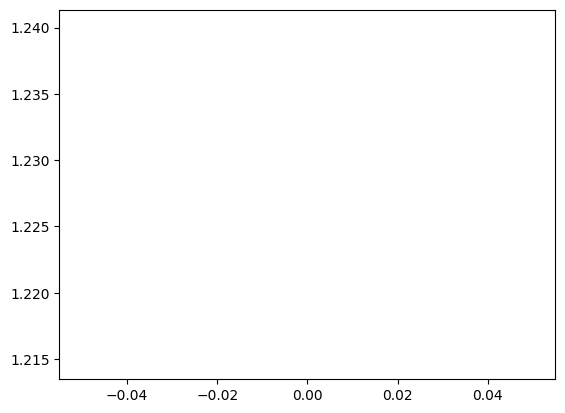

In [45]:
try:
    history = model.fit([a_movieid, a_userid], a_y,
                        epochs=1,  # 20
                        validation_data=([b_movieid, b_userid], b_y))
except KeyboardInterrupt:
    pass

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [46]:
# This is the number that matters. It's the held out
# test set score. Note the + 1, because np.argmax will
# go from 0 to 4, while our ratings go 1 to 5.
metrics.mean_absolute_error(
    np.argmax(b_y, 1)+1,
    np.argmax(model.predict([b_movieid, b_userid]), 1)+1)

7815/7815 [==============================] - 10s 1ms/step


0.6730013237193715

In [47]:
# For comparison's sake, here's the score on the training set.
metrics.mean_absolute_error(
    np.argmax(a_y, 1)+1,
    np.argmax(model.predict([a_movieid, a_userid]), 1)+1)

23443/23443 [==============================] - 30s 1ms/step


0.6575099046065085